# FENE beadspring with variable kuhn length experiment data analysis

In [1]:
import os

import polyflexmd.data_analysis.data.read as read
import polyflexmd.data_analysis.transform.transform as transform
import polyflexmd.data_analysis.theory.kremer_grest as kremer_grest
import polyflexmd.data_analysis.theory.rouse as rouse
import polyflexmd.data_analysis.plot.plot_system as plot_system
import polyflexmd.experiment_runner.config as config
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from pandarallel import pandarallel
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [22]:
sns.set_style("darkgrid")

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [23]:
pandarallel.initialize(
    nb_workers=len(os.sched_getaffinity(0)),
    progress_bar=False,
    use_memory_fs=False
)

INFO: Pandarallel will run on 128 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Read and process data

In [123]:
PATH_EXPERIMENT = "/scratch/ws/0/s4610340-bt-eea1-md-workspace/.dev/test-results/FENE-beadspring-vary-l_K/test-4-FENE-beadspring-vary-l_K-taurus-mpi/e296c212"
NAME_EC = "test-4-FENE-beadspring-vary-l_K-taurus-mpi.toml"
CONTINUE = True
CONTINUE_t_equilibrium = 5000000

In [124]:
CONTINUE = bool(CONTINUE)
CONTINUE_t_equilibrium = int(CONTINUE_t_equilibrium)
PATH_EXPERIMENT = pathlib.Path(PATH_EXPERIMENT)
PATH_SYSTEM_DEF = PATH_EXPERIMENT / "data/initial_system.data"
PATH_EC = PATH_EXPERIMENT / NAME_EC

### Read experiment config

In [125]:
conf = config.read_experiment_config(PATH_EC)
conf

ExperimentConfig(simulation_config=SimulationConfig(job=SlurmJobConfig(account='p_mdpolymer', time='1:00:00', partition='romeo', nodes=2, tasks_per_node=128, ntasks=256, cpus_per_task=1, mem_per_cpu=1000), simulation_model_path=PosixPath('simulations/FENE-beadspring-vary-l_K.lammps'), experiments_path=PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/.dev/test-results'), n_partitions=2, n_tasks_per_partition=128, variables={'kappa_start': 1.0, 'kappa_delta': 5, 'kappa_n_values': 8, 'n_relax_steps': 2000000, 'n_equilibrium_steps': 2000000}), system_creator_config=SystemCreatorConfig(job=SlurmJobConfig(account='p_mdpolymer', time='1:00:00', partition='romeo', nodes=1, tasks_per_node=1, ntasks=1, cpus_per_task=4, mem_per_cpu=1000), venv_path=PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/polyflexmd/.venv'), system_config=AnchoredFENEChainConfig(name='anchored-fene-chain', n_chains=40, n_monomers=128, monomer_type=2, bond_type=1, angle_type=1, bond_length=0.97, box_length=200,

In [126]:
kappas: list[float] = [
    conf.simulation_config.variables["kappa_start"] + conf.simulation_config.variables["kappa_delta"] * i
    for i in range(conf.simulation_config.variables["kappa_n_values"])
]
kappas

[1.0, 6.0, 11.0, 16.0, 21.0, 26.0, 31.0, 36.0]

### Read initial system

In [127]:
system = read.read_lammps_system_data(PATH_SYSTEM_DEF)
system.atoms

,molecule-ID,type,x,y,z,ix,iy,iz
1,1,1,0.000000,0.000000,0.000000,0,0,0
2,1,1,0.764233,-0.425729,-0.419050,0,0,0
3,1,2,0.773821,-0.836732,0.459520,0,0,0
4,1,2,1.285179,-0.524169,-0.303184,0,0,0
5,1,2,0.842282,0.329744,-0.427985,0,0,0
...,...,...,...,...,...,...,...,...
5116,40,2,-8.806796,0.070591,-4.480917,0,0,0
5117,40,2,-8.040260,-0.270179,-3.993886,0,0,0
5118,40,2,-7.295676,-0.582204,-4.531599,0,0,0
5119,40,2,-7.689637,0.070740,-3.932133,0,0,0


In [128]:
system.bonds

,type,atom1,atom2
1,1,1,2
2,1,2,3
3,1,3,4
4,1,4,5
5,1,5,6
...,...,...,...
5076,1,5115,5116
5077,1,5116,5117
5078,1,5117,5118
5079,1,5118,5119


In [129]:
system.angles

,type,atom1,atom2,atom3
1,1,1,2,3
2,1,2,3,4
3,1,3,4,5
4,1,4,5,6
5,1,5,6,7
...,...,...,...,...
5036,1,5114,5115,5116
5037,1,5115,5116,5117
5038,1,5116,5117,5118
5039,1,5117,5118,5119


In [130]:
system.box

-100.000000 100.000000  xlo xhi
-100.000000 100.000000  ylo yhi
-100.000000 100.000000  zlo zhi

### Read and process trajectories

In [131]:
PATH_DATA_PROCESSED = PATH_EXPERIMENT / "data" / "processed"
if CONTINUE:
    PATH_DATA_PROCESSED = PATH_DATA_PROCESSED / "continue"
PATH_DATA_PROCESSED.mkdir(exist_ok=True, parents=True)
PATH_DF_TRAJECTORY_PROCESSED = PATH_DATA_PROCESSED / "trajectory_unfolded_kappas.csv"
PATH_DF_TRAJECTORY_PROCESSED

PosixPath('/scratch/ws/0/s4610340-bt-eea1-md-workspace/.dev/test-results/FENE-beadspring-vary-l_K/test-4-FENE-beadspring-vary-l_K-taurus-mpi/e296c212/data/processed/continue/trajectory_unfolded_kappas.csv')

In [132]:
def read_and_process_kappas_df(experiment_path: pathlib.Path, kappas: list[float]):
    dfs = []
    for i in range(1, len(kappas) + 1):
        paths_trajectories = [
            experiment_path / "data" / f"polymer_relax-{i}.out",
            experiment_path / "data" / f"polymer-{i}.out"
        ]

        if CONTINUE:
            paths_trajectories = [
                experiment_path / "data" / f"polymer_relax-{i}-continue.out",
                experiment_path / "data" / f"polymer-{i}-continue.out"
            ]


        print(f"Reading {paths_trajectories}...")
        if not all(p.exists() for p in paths_trajectories):
            break

        df_trajectory_unfolded = transform.unfold_coordinates_df(
            trajectory_df=transform.join_raw_trajectory_df_with_system_data(
                raw_trajectory_df=read.read_multiple_raw_trajectory_dfs(paths_trajectories),
                system_data=system
            ),
            system_data=system
        )
        df_trajectory_unfolded["kappa"] = kappas[i-1]
        dfs.append(df_trajectory_unfolded)

    return pd.concat(dfs)


if PATH_DF_TRAJECTORY_PROCESSED.exists():
    print("Reading processed...")
    df_trajectory_unfolded_kappas = pd.read_csv(PATH_DF_TRAJECTORY_PROCESSED)
else:
    print("Reading and processing...")
    df_trajectory_unfolded_kappas = read_and_process_kappas_df(PATH_EXPERIMENT, kappas)
    print("Writing...")
    df_trajectory_unfolded_kappas.to_csv(PATH_DF_TRAJECTORY_PROCESSED, index=False)

df_trajectory_unfolded_kappas

Reading processed...


,t,id,type,x,y,z,ix,iy,iz,molecule-ID,kappa
0,5000000,1,1,0.000000,0.000000,0.000000,0,0,0,1,1.0
1,5000000,2,1,0.764233,-0.425729,-0.419050,0,0,0,1,1.0
2,5000000,3,2,1.567190,-0.907186,-0.179678,0,0,0,1,1.0
3,5000000,4,2,2.509110,-0.911944,-0.174130,0,0,0,1,1.0
4,5000000,5,2,2.198440,-0.971394,0.700712,0,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...
9108475,5000000,5116,2,21.345000,-3.692870,-25.368200,0,0,0,40,36.0
9108476,5000000,5117,2,21.817400,-2.831990,-25.641000,0,0,0,40,36.0
9108477,5000000,5118,2,22.317800,-2.059440,-25.915000,0,0,0,40,36.0
9108478,5000000,5119,2,22.691800,-1.303630,-26.291500,0,0,0,40,36.0


In [134]:
df_trajectory_unfolded_kappas.groupby(["kappa"])["t"].describe()

,count,mean,std,min,25%,50%,75%,max
kappa,,,,,,,,
1.0,1116160.0,7.881193e+06,4.003795e+06,4000000.0,4540000.0,5750000.0,11200000.0,16600000.0
6.0,1070080.0,7.522967e+06,3.689100e+06,4000000.0,4520000.0,5300000.0,10500000.0,15700000.0
11.0,1146880.0,8.124107e+06,4.212565e+06,4000000.0,4557500.0,6050000.0,11625000.0,17200000.0
16.0,1157120.0,8.205752e+06,4.281970e+06,4000000.0,4560000.0,6150000.0,11800000.0,17400000.0
21.0,1126400.0,7.961818e+06,4.073477e+06,4000000.0,4547500.0,5850000.0,11325000.0,16800000.0
26.0,1167360.0,8.287719e+06,4.351282e+06,4000000.0,4567500.0,6250000.0,11925000.0,17600000.0
31.0,1198080.0,8.535470e+06,4.558661e+06,4000000.0,4580000.0,6550000.0,12400000.0,18200000.0
36.0,1126400.0,7.961818e+06,4.073477e+06,4000000.0,4547500.0,5850000.0,11325000.0,16800000.0


## Calculate and plot observables relax+equi

In [135]:
l_b_src = .97
L_src = l_b_src*(conf.system_creator_config.system_config.n_monomers-1)
L_src

123.19

### End-to-End distance $\vec{R}$

In [136]:
PATH_ETE = PATH_DATA_PROCESSED / "ete.csv"

if PATH_ETE.exists():
    print("Reading processed...")
    df_ete = pd.read_csv(PATH_ETE, index_col=["kappa", "molecule-ID", "t"])
else:
    print("Processing...")
    df_ete = df_trajectory_unfolded_kappas.groupby("kappa").apply(transform.calc_end_to_end_df)
    print("Writing...")
    df_ete.to_csv(PATH_ETE, index=True)

df_ete

Reading processed...


R_x       R_y       R_z          R
kappa molecule-ID t                                                
1.0   1           4000000    7.63051  -9.46852  24.69790  27.529327
                  4010000    5.87206  -4.33505  21.89870  23.083042
                  4020000    5.80189  -3.50434  23.50720  24.464889
                  4030000    4.03187  -3.74959  20.29490  21.028513
                  4040000    4.15075  -7.40835  21.66180  23.266842
...                              ...       ...       ...        ...
36.0  40          16400000 -52.01500 -28.98230 -29.21000  66.323134
                  16500000 -47.30950 -32.63220 -27.85690  63.867489
                  16600000 -43.61840 -37.62000 -27.13600  63.672535
                  16700000 -45.33990 -26.59330 -19.63880  56.112321
                  16800000 -44.48230 -24.70920  -4.05742  51.045884

[70840 rows x 4 columns]

In [137]:
df_ete["t/LJ"] = df_ete.index.get_level_values("t").map(lambda x: x * 0.0025)
df_ete["R^2"] = df_ete["R"] ** 2
df_ete

R_x       R_y       R_z          R     t/LJ  \
kappa molecule-ID t                                                            
1.0   1           4000000    7.63051  -9.46852  24.69790  27.529327  10000.0   
                  4010000    5.87206  -4.33505  21.89870  23.083042  10025.0   
                  4020000    5.80189  -3.50434  23.50720  24.464889  10050.0   
                  4030000    4.03187  -3.74959  20.29490  21.028513  10075.0   
                  4040000    4.15075  -7.40835  21.66180  23.266842  10100.0   
...                              ...       ...       ...        ...      ...   
36.0  40          16400000 -52.01500 -28.98230 -29.21000  66.323134  41000.0   
                  16500000 -47.30950 -32.63220 -27.85690  63.867489  41250.0   
                  16600000 -43.61840 -37.62000 -27.13600  63.672535  41500.0   
                  16700000 -45.33990 -26.59330 -19.63880  56.112321  41750.0   
                  16800000 -44.48230 -24.70920  -4.05742  51.045884  42000.0   

                                    R^2  
kappa molecule-ID t                      
1.0   1           4000000    757.863818  
                  4010000    532.826809  
                  4020000    598.530778  
                  4030000    442.198367  
                  4040000    541.345955  
...                                 ...  
36.0  40          16400000  4398.758038  
                  16500000  4079.056145  
                  16600000  4054.191715  
                  16700000  3148.592602  
                  16800000  2605.682235  

[70840 rows x 6 columns]

In [138]:
df_ete_mean = df_ete.groupby(["kappa", "t"])[["R^2"]].mean()
df_ete_mean["l_K"] = kremer_grest.bare_kuhn_length(
    np.array(df_ete_mean.index.get_level_values("kappa")),
    l_b=l_b_src
)
df_ete_mean

R^2        l_K
kappa t                               
1.0   4000000    265.578960   1.854017
      4010000    251.999045   1.854017
      4020000    267.421520   1.854017
      4030000    256.391835   1.854017
      4040000    258.553525   1.854017
...                     ...        ...
36.0  16400000  4477.384218  68.870000
      16500000  4747.525768  68.870000
      16600000  4661.216820  68.870000
      16700000  4454.087126  68.870000
      16800000  4272.851897  68.870000

[1771 rows x 2 columns]

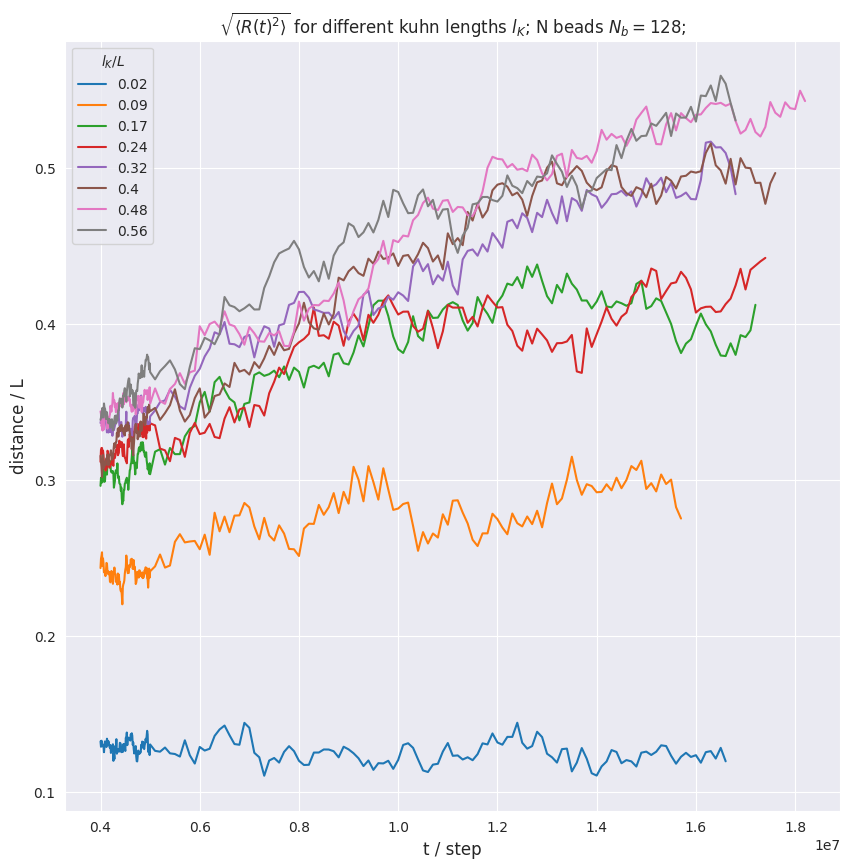

In [139]:
kappa_colors = sns.color_palette(n_colors=len(kappas))

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))
ax.set(
    title=f'$\sqrt{{\\langle R(t)^2 \\rangle }}$ for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.system_creator_config.system_config.n_monomers}$;',
    ylabel="distance / L",
    xlabel="t / step"
)

sns.lineplot(
    x=df_ete_mean.index.get_level_values("t"),
    y=np.sqrt(df_ete_mean["R^2"]) / L_src,
    hue=(df_ete_mean["l_K"]/L_src).round(2).astype("category"),
    color=kappa_colors,
    ax=ax
)

ax.get_legend().set_title("$l_K/L$")

/lustre/scratch2/ws/0/s4610340-bt-eea1-md-workspace/polyflexmd/.venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/lustre/scratch2/ws/0/s4610340-bt-eea1-md-workspace/polyflexmd/.venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/lustre/scratch2/ws/0/s4610340-bt-eea1-md-workspace/polyflexmd/.venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/lustre/scratch2/ws/0/s4610340-bt-eea1-md-workspace/polyflexmd/.venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could 

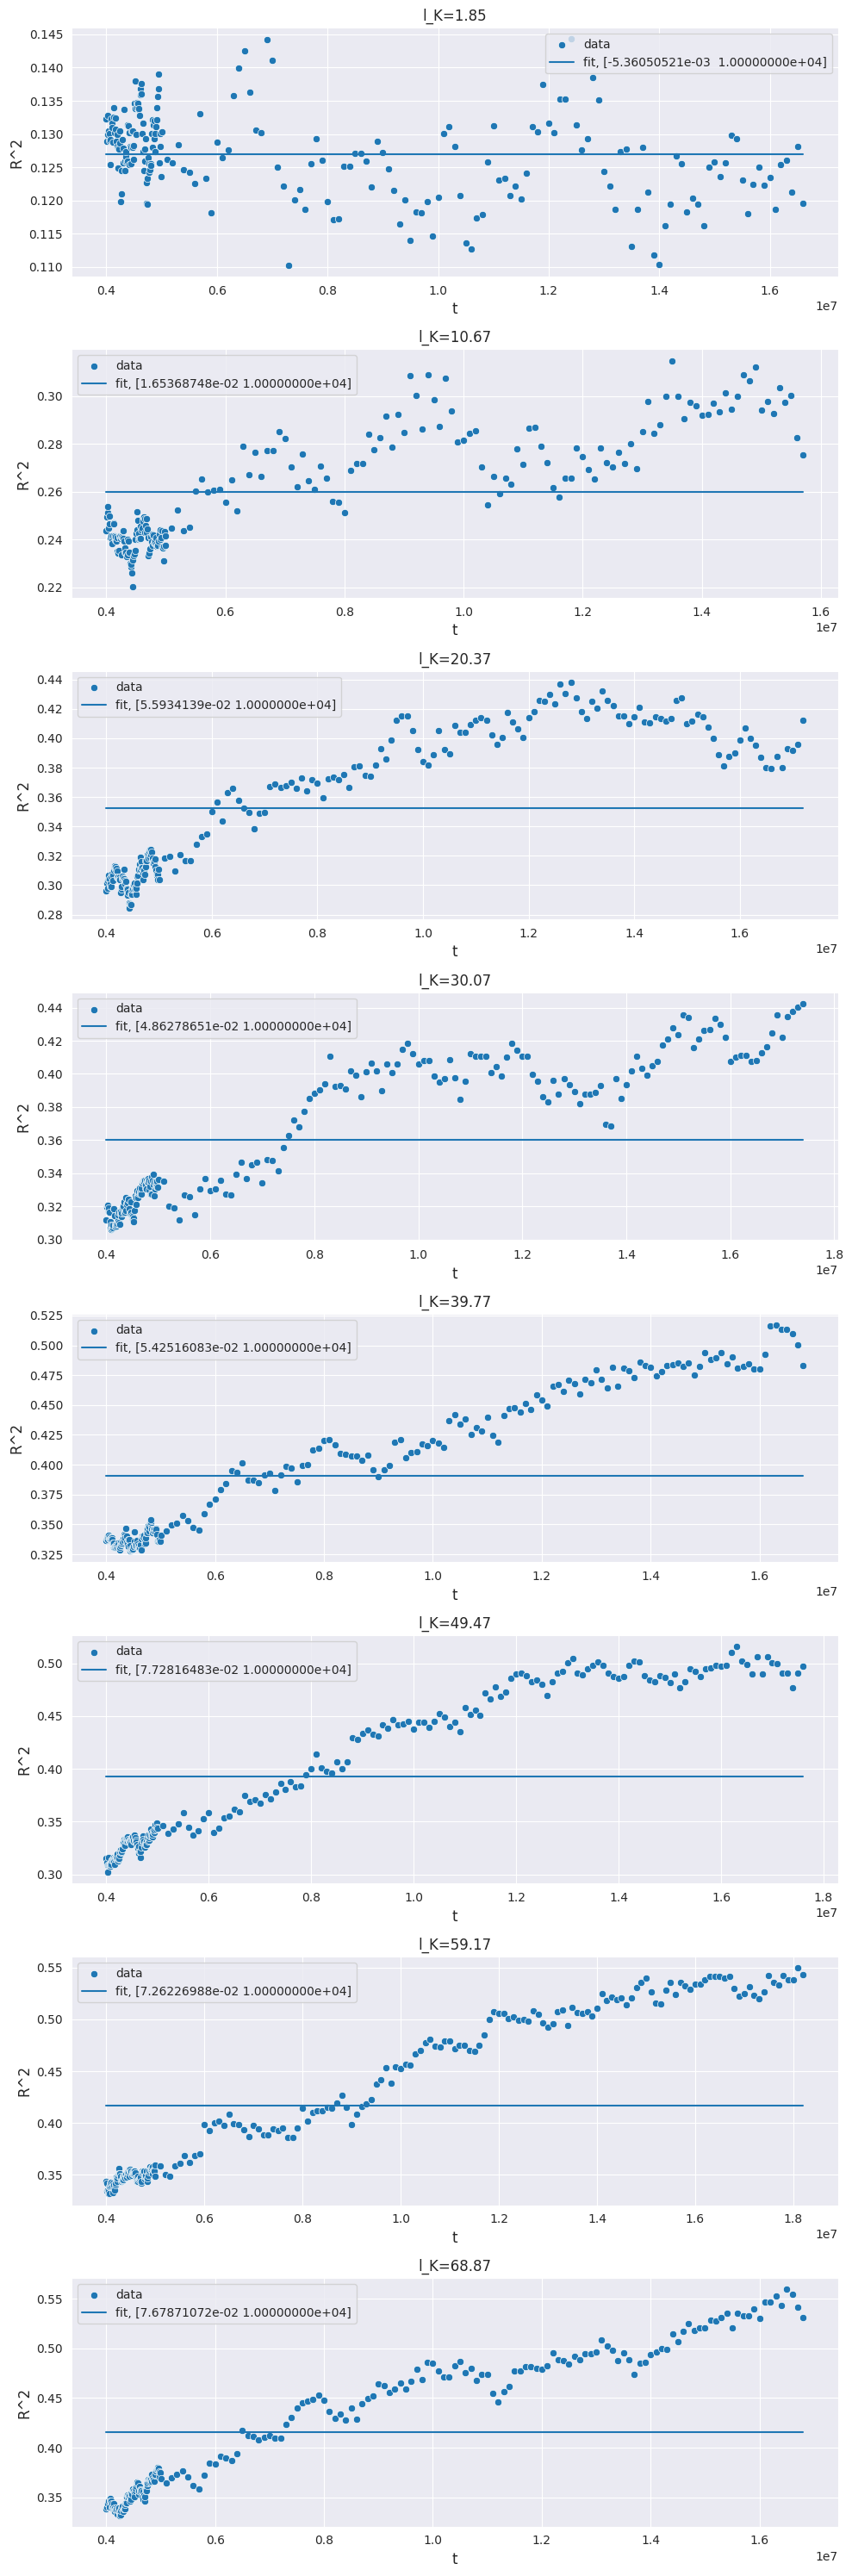

In [140]:
import scipy.optimize
import functools

axs: list[plt.Axes]
fig: plt.Figure
fig, axs = plt.subplots(nrows=len(kappas), figsize=(10,30))

estimated_R_sq = []

def f_relax(ts, A, tau, eps):
    return A*(1-np.exp(-ts/tau))+eps

for (l_K, df_ete_mean_l_K), ax in zip(df_ete_mean.groupby("l_K"), axs):

    ax.set_title(f"l_K={l_K:.2f}")
    t_min = df_ete_mean_l_K.index.get_level_values("t").min()
    eps = np.sqrt(df_ete_mean_l_K.loc[pd.IndexSlice[:, t_min], :]["R^2"].iloc[0])/L_src
    popt, pcov = scipy.optimize.curve_fit(
        functools.partial(f_relax, eps=eps),
        df_ete_mean_l_K.index.get_level_values("t"),
        np.sqrt(df_ete_mean_l_K["R^2"]) / L_src,
        p0=(.5, 1e4)
    )
    estimated_R_sq.append((popt[0]*L_src)**2)

    sns.scatterplot(
        x=df_ete_mean_l_K.index.get_level_values("t"),
        y=np.sqrt(df_ete_mean_l_K["R^2"]) / L_src,
        ax=ax,
        label="data"
    )
    sns.lineplot(
        x=df_ete_mean_l_K.index.get_level_values("t"),
        y=f_relax(df_ete_mean_l_K.index.get_level_values("t"), *popt, eps),
        ax=ax,
        label=f"fit, {popt}"
    )
fig.tight_layout()

## Equilibrium statistics

In [141]:
t_equilibrium = conf.simulation_config.variables["n_relax_steps"] if not CONTINUE else CONTINUE_t_equilibrium
t_equilibrium

5000000

In [142]:
df_trajectory_unfolded_kappas_equi = df_trajectory_unfolded_kappas.loc[df_trajectory_unfolded_kappas["t"] > t_equilibrium]
df_trajectory_unfolded_kappas_equi

,t,id,type,x,y,z,ix,iy,iz,molecule-ID,kappa
5120,5100000,1,1,0.000000,0.000000,0.000000,0,0,0,1,1.0
5121,5100000,2,1,0.764233,-0.425729,-0.419050,0,0,0,1,1.0
5122,5100000,3,2,1.053540,-1.094420,0.153407,0,0,0,1,1.0
5123,5100000,4,2,0.097119,-1.078820,0.321348,0,0,0,1,1.0
5124,5100000,5,2,-0.859365,-0.964502,0.149614,0,0,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...
8591355,16800000,5116,2,-44.057200,-26.072400,-7.596910,0,0,0,40,36.0
8591356,16800000,5117,2,-44.262800,-25.692900,-6.755970,0,0,0,40,36.0
8591357,16800000,5118,2,-44.119500,-25.356300,-5.811330,0,0,0,40,36.0
8591358,16800000,5119,2,-44.186300,-25.003500,-4.940980,0,0,0,40,36.0


In [143]:
df_ete_kappas_equi = df_ete.iloc[df_ete.index.get_level_values("t") >= t_equilibrium]
df_ete_kappas_equi

R_x       R_y       R_z          R     t/LJ  \
kappa molecule-ID t                                                             
1.0   1           5000000   -4.066650 -22.57620  19.42250  30.057544  12500.0   
                  5100000  -10.613000 -17.18830  14.24610  24.718916  12750.0   
                  5200000    2.243800 -15.55300  17.18400  23.285624  13000.0   
                  5300000    4.884110  -2.59520  11.47240  12.735994  13250.0   
                  5400000    0.683936  -6.22183  13.54600  14.922234  13500.0   
...                               ...       ...       ...        ...      ...   
36.0  40          16400000 -52.015000 -28.98230 -29.21000  66.323134  41000.0   
                  16500000 -47.309500 -32.63220 -27.85690  63.867489  41250.0   
                  16600000 -43.618400 -37.62000 -27.13600  63.672535  41500.0   
                  16700000 -45.339900 -26.59330 -19.63880  56.112321  41750.0   
                  16800000 -44.482300 -24.70920  -4.05742  51.045884  42000.0   

                                    R^2  
kappa molecule-ID t                      
1.0   1           5000000    903.455955  
                  5100000    611.024791  
                  5200000    542.220303  
                  5300000    162.205555  
                  5400000    222.673053  
...                                 ...  
36.0  40          16400000  4398.758038  
                  16500000  4079.056145  
                  16600000  4054.191715  
                  16700000  3148.592602  
                  16800000  2605.682235  

[38840 rows x 6 columns]

In [144]:
df_ete_mean_equi = df_ete_mean.iloc[df_ete_mean.index.get_level_values("t") > t_equilibrium]
df_ete_mean_equi

R^2        l_K
kappa t                               
1.0   5100000    241.837129   1.854017
      5200000    239.781294   1.854017
      5300000    250.094847   1.854017
      5400000    235.797162   1.854017
      5500000    234.157788   1.854017
...                     ...        ...
36.0  16400000  4477.384218  68.870000
      16500000  4747.525768  68.870000
      16600000  4661.216820  68.870000
      16700000  4454.087126  68.870000
      16800000  4272.851897  68.870000

[963 rows x 2 columns]

### Mean bond length

In [145]:
l_b_df = transform.extract_bond_lengths_df_kappas(df_trajectory_unfolded_kappas_equi, t_equilibrium=conf.simulation_config.variables["n_relax_steps"])
l_b_df

,,l_b
kappa,i,
1.0,0,0.97000
6.0,0,0.97000
11.0,0,0.97000
16.0,0,0.97000
21.0,0,0.97000
...,...,...
16.0,670559,NaN
21.0,670559,NaN
26.0,670559,NaN


In [146]:
l_b_df.groupby("kappa").describe()

l_b                                                              \
          count      mean       std       min       25%       50%       75%   
kappa                                                                         
1.0    589280.0  0.970223  0.033341  0.854011  0.946844  0.968200  0.991026   
6.0    543560.0  0.970143  0.033327  0.846532  0.946749  0.968143  0.990972   
11.0   619760.0  0.970142  0.033256  0.852703  0.946837  0.968100  0.990881   
16.0   629920.0  0.970069  0.033333  0.853286  0.946676  0.968060  0.990830   
21.0   599440.0  0.970223  0.033370  0.848088  0.946752  0.968208  0.991101   
26.0   640080.0  0.970074  0.033330  0.855591  0.946657  0.968065  0.990894   
31.0   670560.0  0.970155  0.033344  0.847216  0.946689  0.968163  0.991022   
36.0   599440.0  0.970151  0.033347  0.847853  0.946745  0.968141  0.991036   

                 
            max  
kappa            
1.0    1.163436  
6.0    1.181109  
11.0   1.172310  
16.0   1.194332  
21.0   1.175644  
26.0   1.175027  
31.0   1.177026  
36.0   1.186789

In [147]:
l_b = conf.system_creator_config.system_config.bond_length
l_b

0.97

### Mean contour length

In [148]:
L_contour = l_b*(conf.system_creator_config.system_config.n_monomers-1)
L_contour

123.19

### Kuhn lengths

Svaneborg (8)

In [149]:
l_ks = kremer_grest.bare_kuhn_length(np.array(kappas), l_b)
l_ks

array([ 1.85401695, 10.67085829, 20.37000013, 30.07      , 39.77      ,
       49.47      , 59.17      , 68.87      ])

In [150]:
l_ks / L_contour

array([0.01505006, 0.08662114, 0.16535433, 0.24409449, 0.32283465,
       0.4015748 , 0.48031496, 0.55905512])

### Number of Kuhn segments $N_K$

Estimate $N_K = L / l_K$ as in Svaneborg (6)

In [151]:
N_Ks = (L_contour / l_ks)
N_Ks

array([66.44491561, 11.54452591,  6.04761901,  4.09677419,  3.09756098,
        2.49019608,  2.08196721,  1.78873239])

### End-to-End distance squared $\langle R^2 \rangle$

Estimate $\langle R^2 \rangle$ as average over ensemble and then over time in equilibrium

In [152]:
df_ete_sq_t_mean_kappas = transform.calculate_ete_sq_t_avg_df_kappas(df_ete_mean_equi, t_equilibrium)
df_ete_sq_t_mean_kappas

,R^2
kappa,
1.0,237.115906
6.0,1184.873677
11.0,2320.994874
16.0,2333.171553
21.0,2923.125935
26.0,3054.182419
31.0,3394.817593
36.0,3366.944138


### Summarize statistics by kappas

In [153]:
df_kuhn_summary = pd.DataFrame({
    "R^2": df_ete_sq_t_mean_kappas["R^2"],
    "N_K": N_Ks,
    "l_K": l_ks
}, index=df_ete_sq_t_mean_kappas.index)
df_kuhn_summary

,R^2,N_K,l_K
kappa,,,
1.0,237.115906,66.444916,1.854017
6.0,1184.873677,11.544526,10.670858
11.0,2320.994874,6.047619,20.370000
16.0,2333.171553,4.096774,30.070000
21.0,2923.125935,3.097561,39.770000
26.0,3054.182419,2.490196,49.470000
31.0,3394.817593,2.081967,59.170000
36.0,3366.944138,1.788732,68.870000


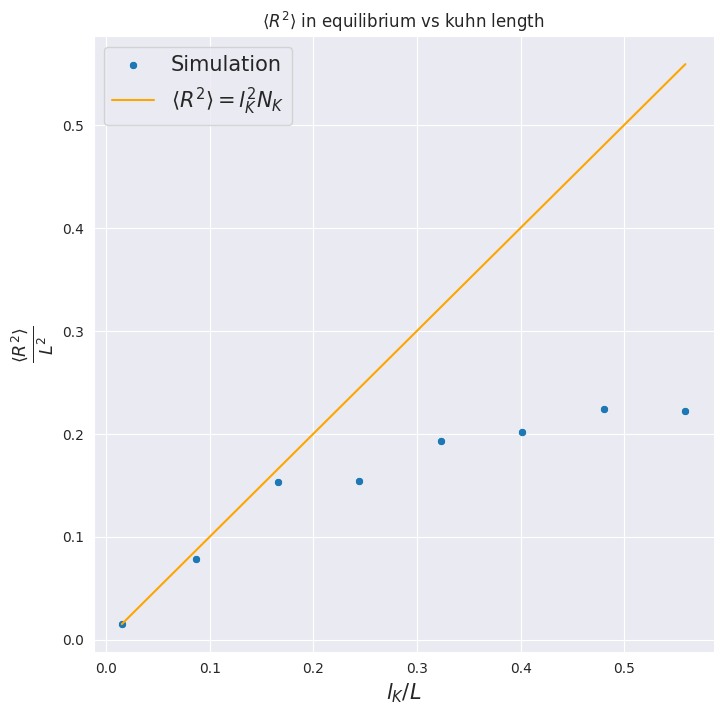

In [154]:
fig, ax = plt.subplots(figsize=(8,8))

sns.scatterplot(
    x=df_kuhn_summary["l_K"]/L_contour,
    y=df_kuhn_summary["R^2"]/L_contour**2,
    ax=ax,
    label="Simulation"
)

sns.lineplot(
    x=df_kuhn_summary["l_K"]/L_contour,
    y=(df_kuhn_summary["l_K"]**2 * N_Ks) / L_contour**2,
    label=r"$\langle R^2 \rangle = l_K^2 N_K$",
    color="orange"
)

ax.set(
    title=r"$\langle R^2 \rangle$ in equilibrium vs kuhn length",
    xlabel="$l_K / L$",
    ylabel=r"$\frac{\langle R^2 \rangle}{L^2}$"
)

ax.legend(fontsize=15)
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(18)

In [155]:
df_kuhn_summary["l_K"]**2 * df_kuhn_summary["N_K"] / df_kuhn_summary["R^2"]

kappa
1.0     0.963227
6.0     1.109437
11.0    1.081166
16.0    1.587677
21.0    1.676037
26.0    1.995365
31.0    2.147141
36.0    2.519821
dtype: float64

### ETE change $ \langle (\Delta R(t))^2 \rangle $

In [156]:
df_ete_change_kappas_equi = transform.calculate_ens_avg_df_ete_change_kappas(df_ete_kappas_equi)
df_ete_change_kappas_equi["l_K"] = kremer_grest.bare_kuhn_length(df_ete_change_kappas_equi["kappa"], l_b=l_b)
df_ete_change_kappas_equi

,dR^2,kappa,l_K
t,,,
5000000,0.000000,1.0,1.854017
5100000,69.089874,1.0,1.854017
5200000,118.014124,1.0,1.854017
5300000,178.076304,1.0,1.854017
5400000,177.309104,1.0,1.854017
...,...,...,...
16400000,4038.744651,36.0,68.870000
16500000,4428.031836,36.0,68.870000
16600000,4441.907501,36.0,68.870000


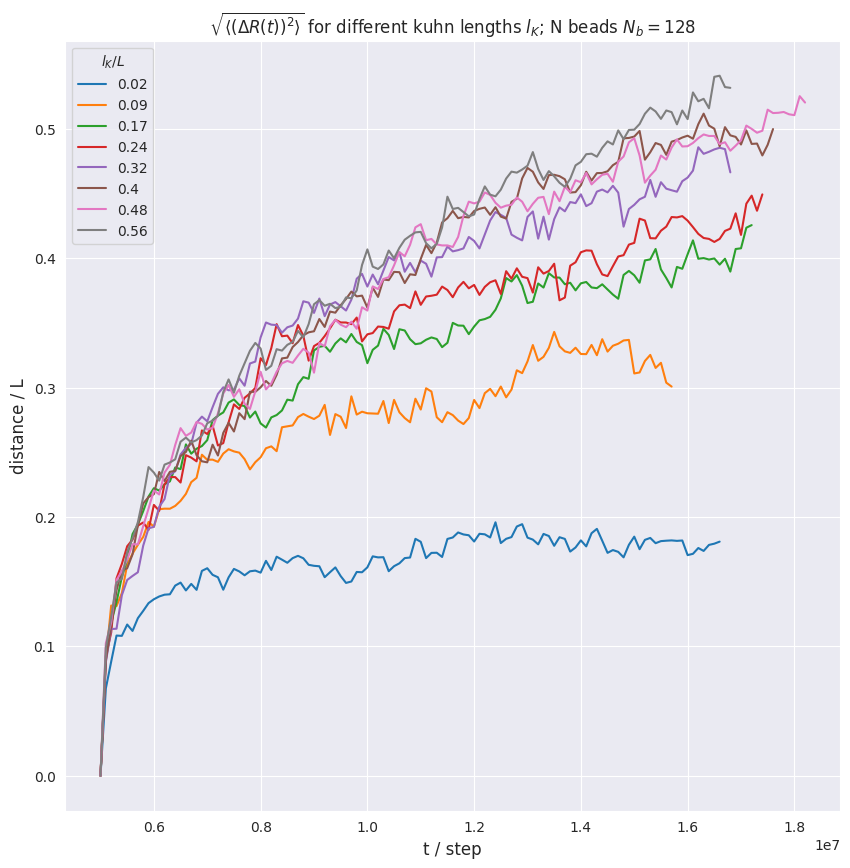

In [157]:
ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))
ax.set(
    title=f'$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} $ for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.system_creator_config.system_config.n_monomers}$',
    ylabel="distance / L",
    xlabel="t / step"
)

sns.lineplot(
    x=df_ete_change_kappas_equi.index.get_level_values("t"),
    y=np.sqrt(df_ete_change_kappas_equi["dR^2"]) / L_contour,
    hue=(df_ete_change_kappas_equi["l_K"]/L_contour).round(2).astype("category"),
    color=kappa_colors,
    ax=ax
)

ax.get_legend().set_title("$l_K/L$")

## Compare with Rouse model

### Transform time

In [158]:
df_ete_change_kappas_equi["t/LJ"] = df_ete_change_kappas_equi.index.get_level_values("t").map(lambda t: t*0.0025)
df_ete_change_kappas_equi["t/LJ rescaled"] = df_ete_change_kappas_equi["t/LJ"]-df_ete_change_kappas_equi["t/LJ"].min()
df_ete_change_kappas_equi

,dR^2,kappa,l_K,t/LJ,t/LJ rescaled
t,,,,,
5000000,0.000000,1.0,1.854017,12500.0,0.0
5100000,69.089874,1.0,1.854017,12750.0,250.0
5200000,118.014124,1.0,1.854017,13000.0,500.0
5300000,178.076304,1.0,1.854017,13250.0,750.0
5400000,177.309104,1.0,1.854017,13500.0,1000.0
...,...,...,...,...,...
16400000,4038.744651,36.0,68.870000,41000.0,28500.0
16500000,4428.031836,36.0,68.870000,41250.0,28750.0
16600000,4441.907501,36.0,68.870000,41500.0,29000.0


### Analytical $\tau_R$

Svaneborg (15)

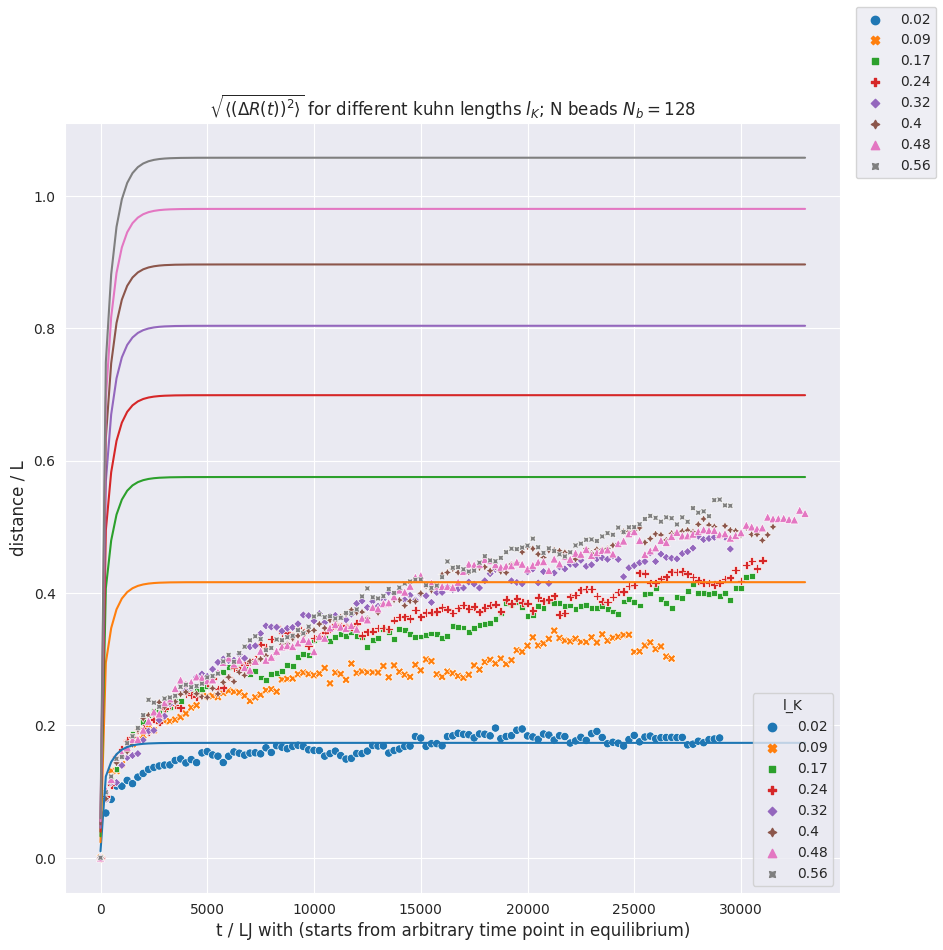

In [177]:
import matplotlib.legend

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))
ax.set(
    title=f'$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} $ for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.system_creator_config.system_config.n_monomers}$',
    ylabel="distance / L",
    xlabel="t / LJ with (starts from arbitrary time point in equilibrium)"
)

plot = sns.scatterplot(
    x=df_ete_change_kappas_equi["t/LJ rescaled"],
    y=np.sqrt(df_ete_change_kappas_equi["dR^2"]) / L_contour,
    hue=(df_ete_change_kappas_equi["l_K"]/L_contour).round(2).astype("category"),
    color=kappa_colors,
    style=(df_ete_change_kappas_equi["l_K"]/L_contour).round(2).astype("category"),
    ax=ax
)

lines = []
labels = []

for i, (l_K, N_K) in enumerate(zip(df_kuhn_summary["l_K"], df_kuhn_summary["N_K"])):
    ts = df_ete_change_kappas_equi["t/LJ rescaled"].unique()
    zeta = 1  # LJ
    tau_rouse = rouse.rouse_relaxation_time(
        N=N_K,
        l=l_K,
        zeta=1,
        T=1,
        k_B=1
    )

    rouse_predictions = rouse.rouse_g_4(
        t=ts,
        tau_R=tau_rouse,
        p_max=conf.system_creator_config.system_config.n_monomers,
        N_b=N_K,
        l_b=l_K
    )
    line = ax.plot(
        ts,
        np.sqrt(rouse_predictions) / L_contour,
        color=kappa_colors[i]
    )
    lines.append(line)
    labels.append(f"$\sqrt{{g_4(t)}}$ for $l_K/L = {np.round(l_K/L_contour, 2)}$")

fig.legend(loc='outside right upper')

### Fit $\tau_R$

[Text(0.5, 1.0, '$ \\sqrt {\\langle (\\Delta R(t))^2 \\rangle} $: Simulation and fit of Rouse model with free parameter $\\tau_R$ for different kuhn lengths $l_K$; N beads $N_b=128$'),
 Text(0, 0.5, 'distance / L'),
 Text(0.5, 0, 't / LJ with (starts from arbitrary time point in equilibrium)')]

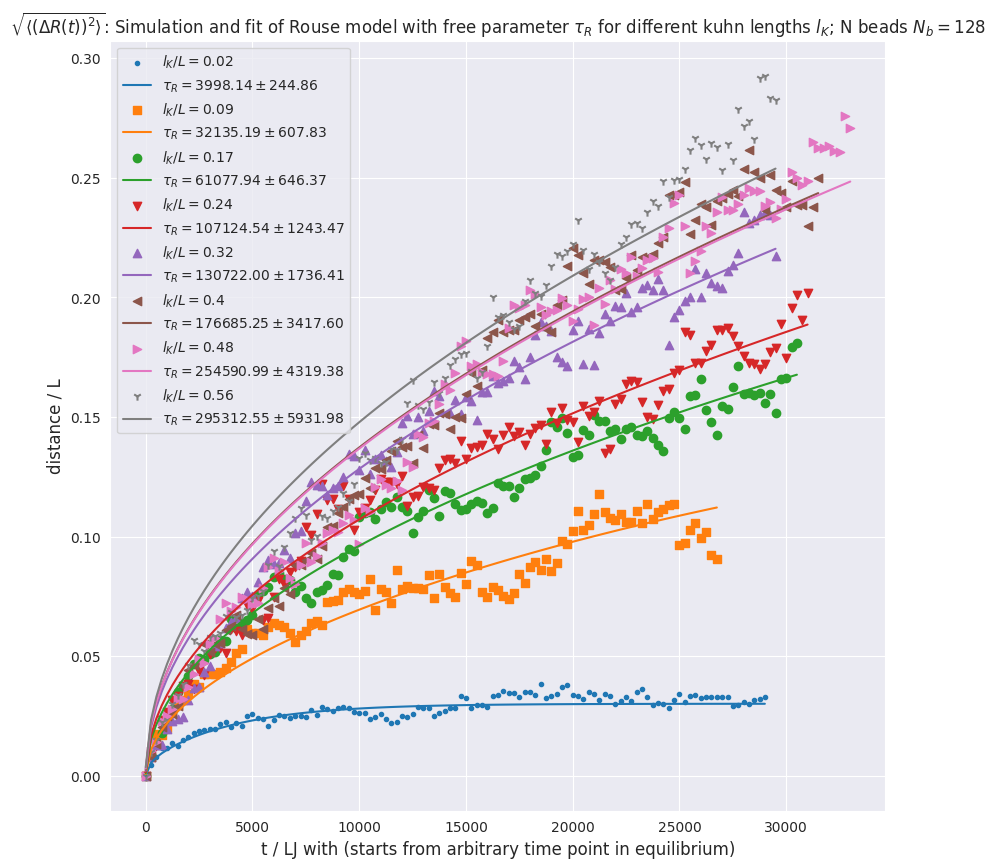

In [122]:
import matplotlib.markers

ax: plt.Axes
fig: plt.Figure
fig, ax = plt.subplots(figsize=(10,10))

for i, (kappa, df_ete_change_kappas_equi_kappa) in enumerate(df_ete_change_kappas_equi.groupby("kappa")):
    l_K = df_kuhn_summary.loc[kappa]["l_K"]
    N_K = df_kuhn_summary.loc[kappa]["N_K"]
    popt, pcov = scipy.optimize.curve_fit(
        functools.partial(rouse.rouse_g_4, N_b=N_K, l_b=l_K, p_max=conf.system_creator_config.system_config.n_monomers),
        df_ete_change_kappas_equi_kappa["t/LJ rescaled"],
        df_ete_change_kappas_equi_kappa["dR^2"],
        p0=(1000,)
    )

    ax.scatter(
        df_ete_change_kappas_equi_kappa["t/LJ rescaled"],
        df_ete_change_kappas_equi_kappa["dR^2"] / L_contour**2,
        label=f"$l_K/L={np.round(l_K/L_contour, 2)}$",
        marker= list(matplotlib.markers.MarkerStyle.markers.keys())[i],
        color=kappa_colors[i]
    )
    ax.plot(
        df_ete_change_kappas_equi_kappa["t/LJ rescaled"],
        rouse.rouse_g_4(
            t=df_ete_change_kappas_equi_kappa["t/LJ rescaled"],
            N_b=N_K,
            l_b=l_K,
            p_max=conf.system_creator_config.system_config.n_monomers,
            tau_R=popt[0]
        ) / L_contour**2,
        label=f"$\\tau_R={popt[0]:.2f} \pm {np.sqrt(np.diag(pcov))[0]:.2f}$",
        color=kappa_colors[i]
    )

ax.legend()

ax.set(
    title=f'$ \sqrt {{\langle (\Delta R(t))^2 \\rangle}} $: Simulation and fit of Rouse model with free parameter $\\tau_R$ for different kuhn lengths $l_K$; '
          f'N beads $N_b={conf.system_creator_config.system_config.n_monomers}$',
    ylabel="distance / L",
    xlabel="t / LJ with (starts from arbitrary time point in equilibrium)"
)